In [6]:
import xarray as xr
import rioxarray as rioxr

import geopandas as geopd
import pandas as pd

import numpy as np

import os
import pathlib

from parallelbar import progress_map



import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 300
plt.style.use('dark_background')

In [7]:
src_path = '/home/iielse/Documents/DIWA/data/copernicus_climate/data/1985-06-potential_evaporation.nc'
with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
    
    data = data_array.copy()
    data = data.rio.write_crs("epsg:4326")

In [8]:
counter = 0
hours = []
for time_step in data.valid_time:
    time = time_step.item()
    one_step_data = data.sel({'valid_time':time})
    hours.append(one_step_data)
    counter += 1
    if counter == 24:
        break

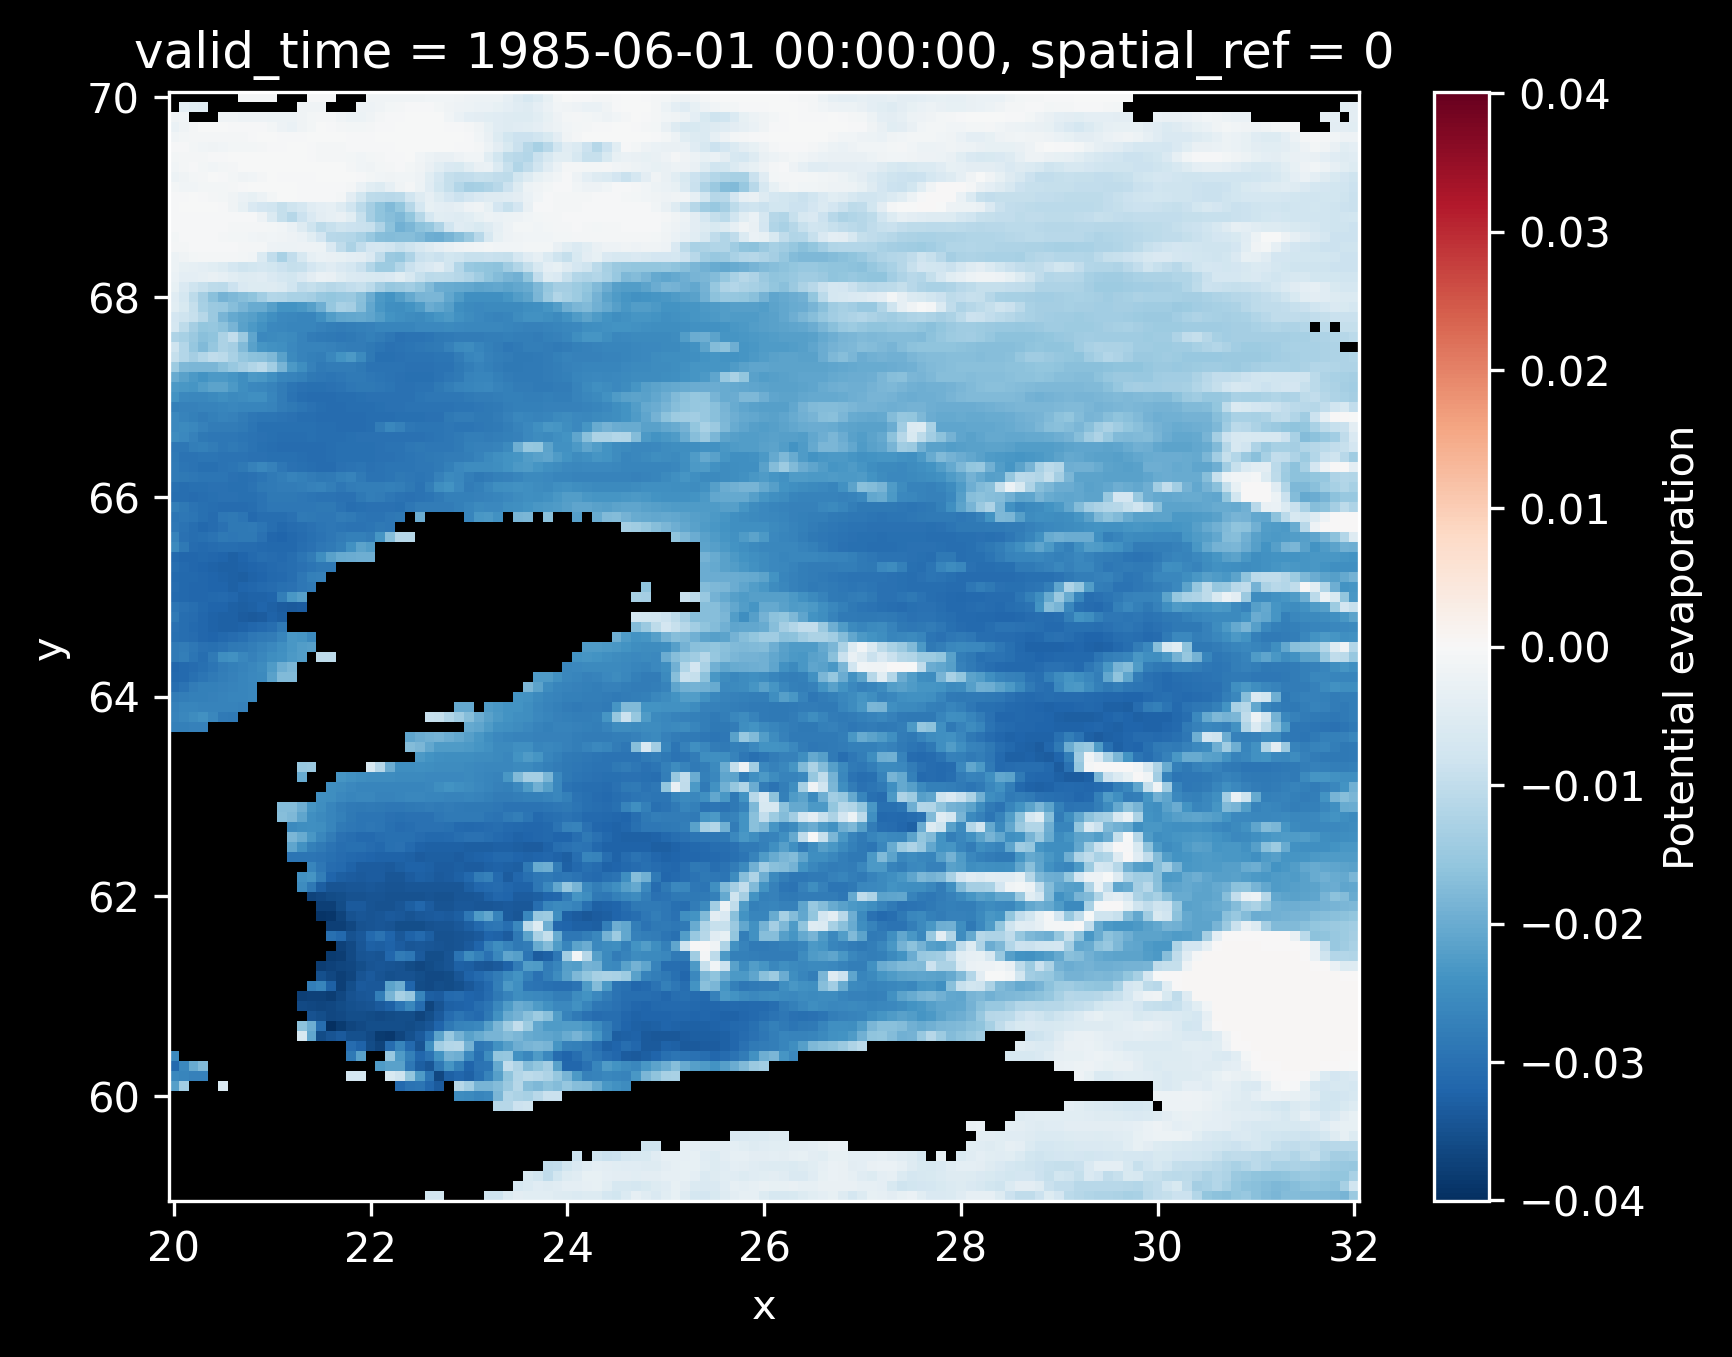

In [9]:
hours[0].plot(cbar_kwargs={'label': one_step_data.long_name})

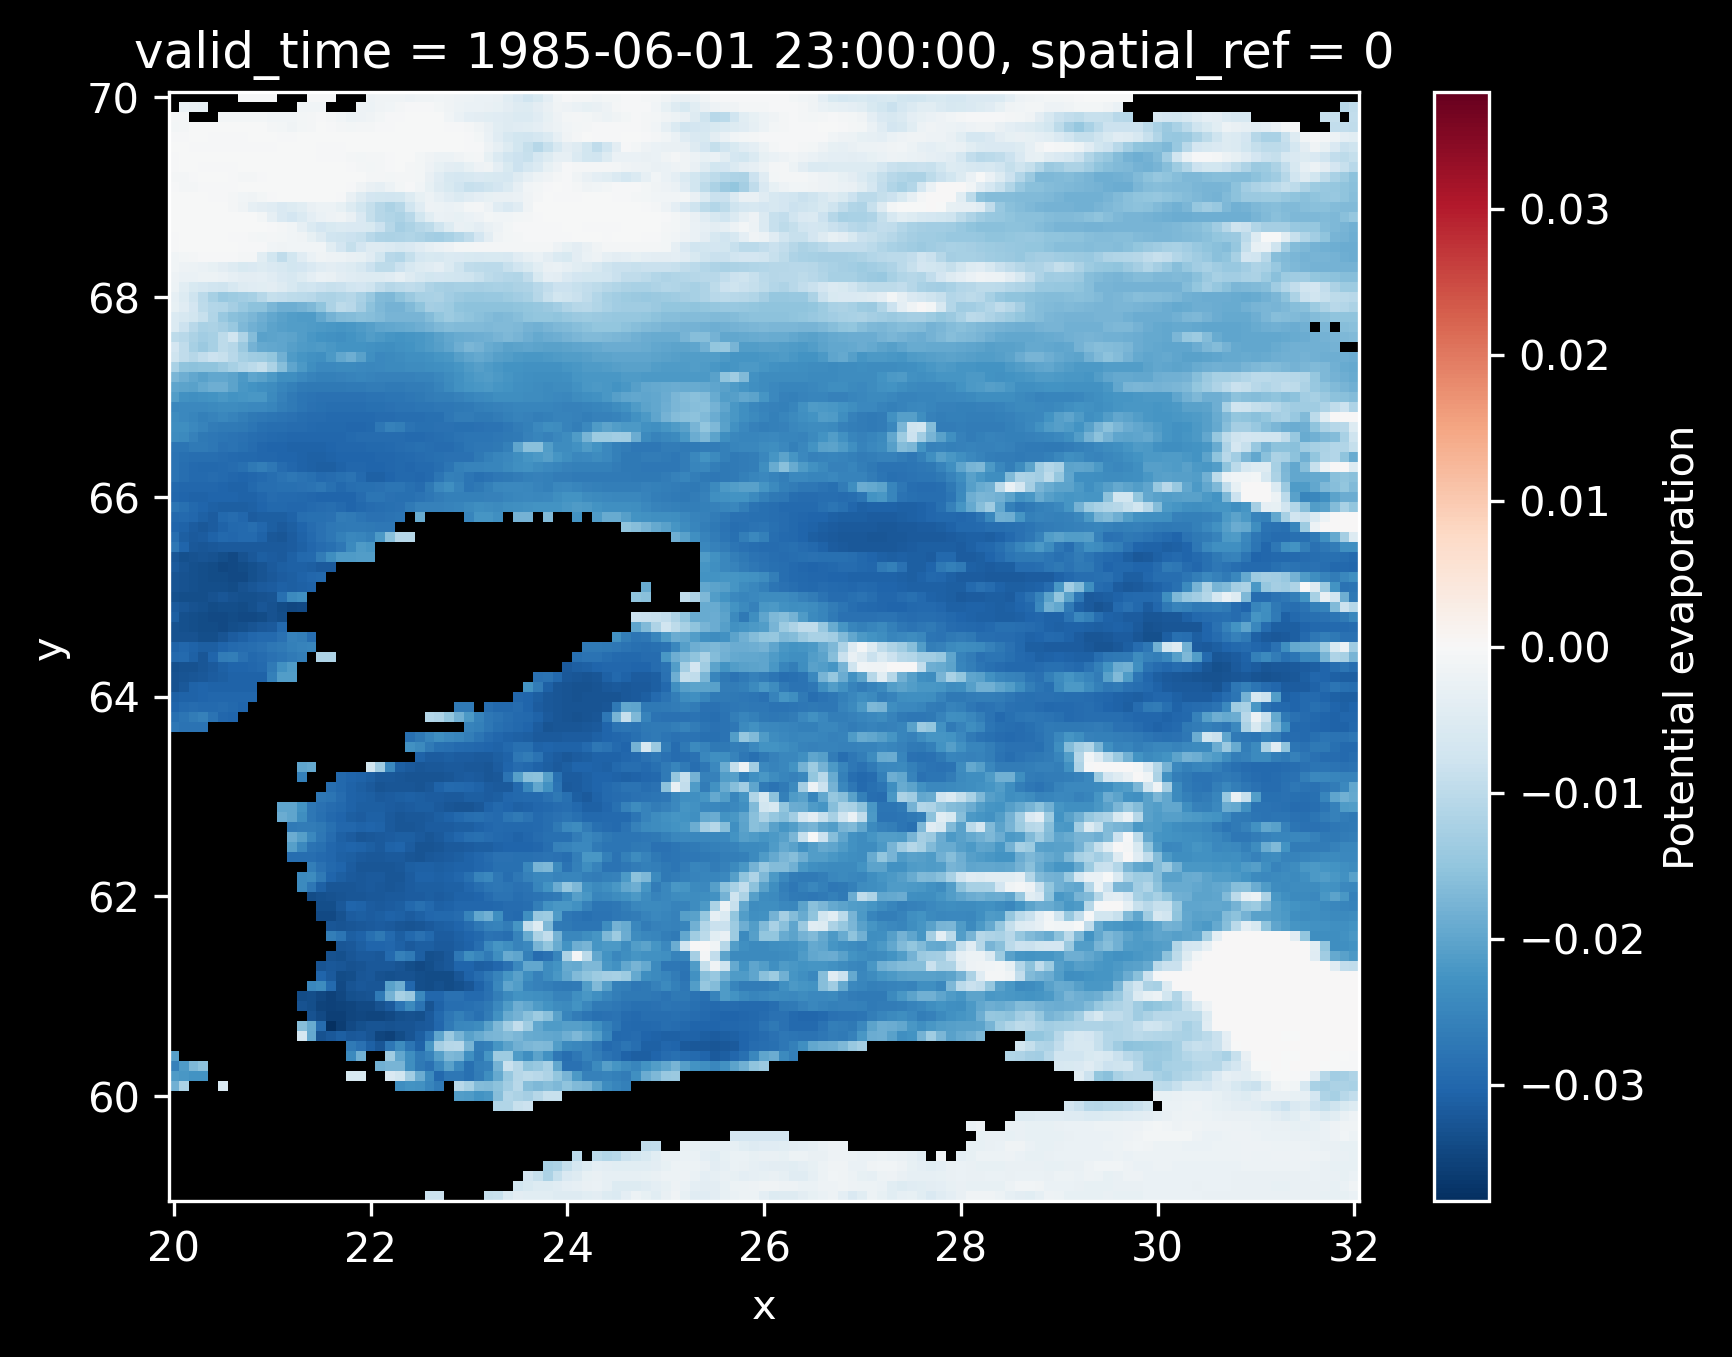

In [10]:
hours[23].plot(cbar_kwargs={'label': one_step_data.long_name})

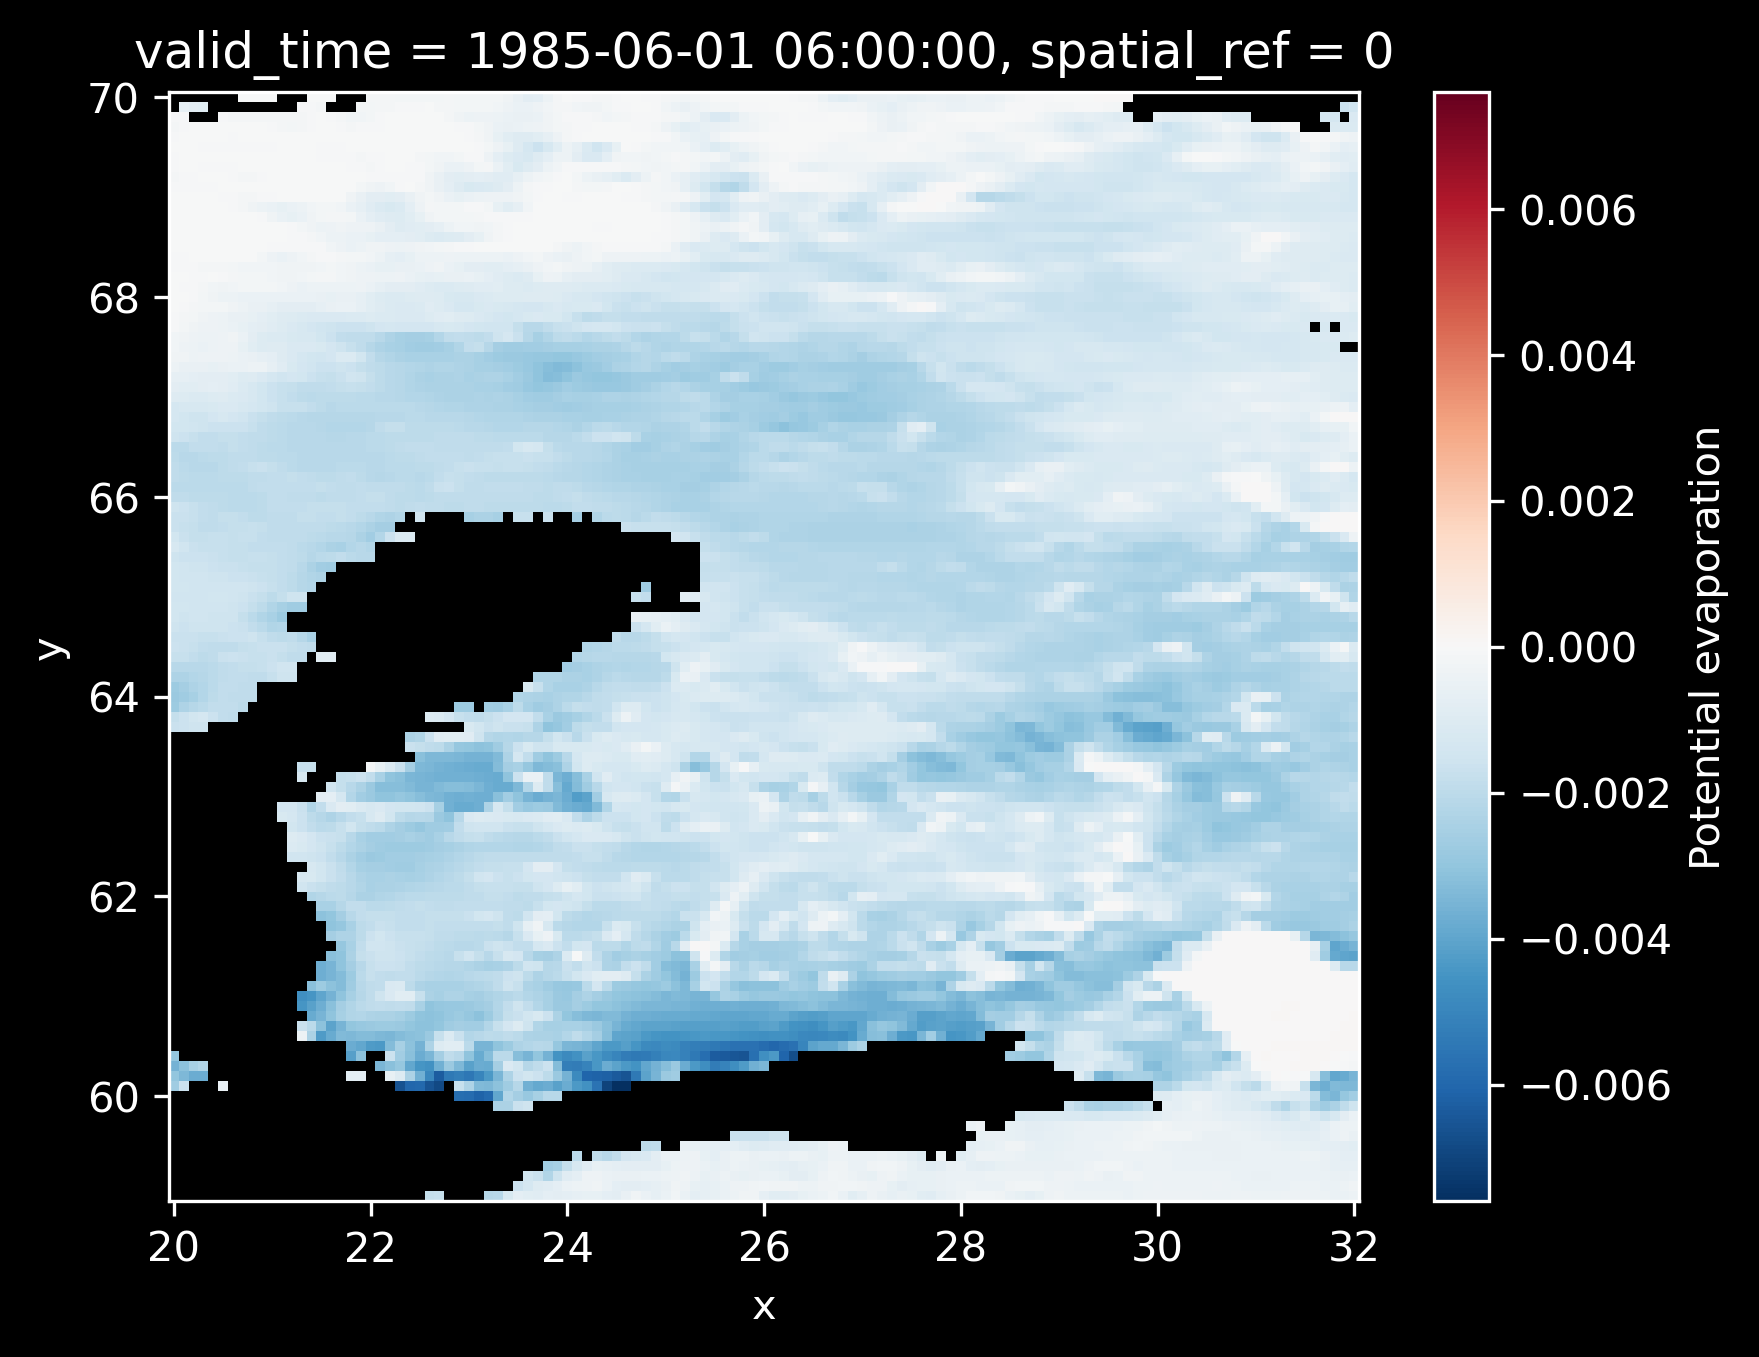

In [31]:
hours[6].plot(cbar_kwargs={'label': one_day_data.long_name})

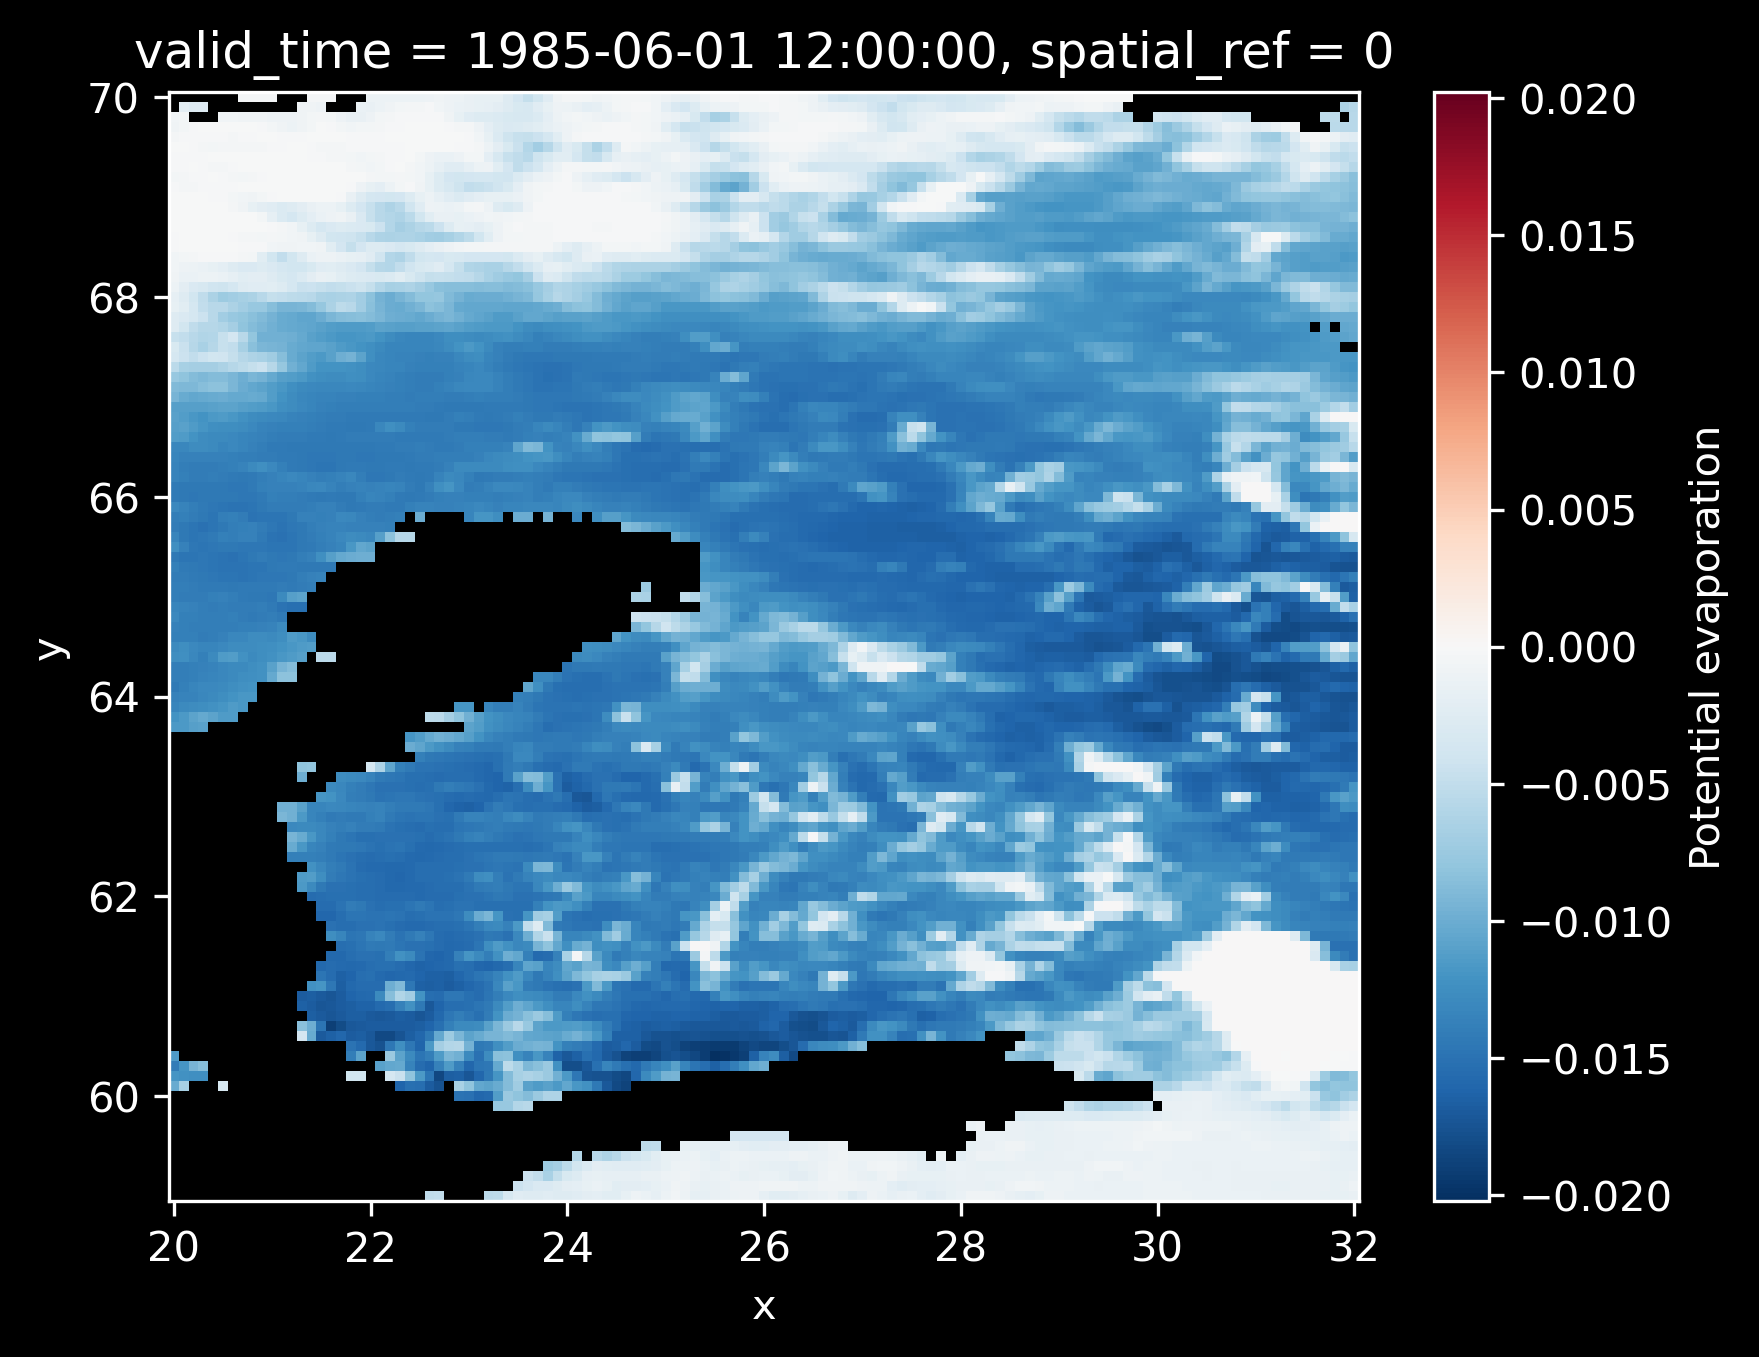

In [32]:
hours[12].plot(cbar_kwargs={'label': one_day_data.long_name})

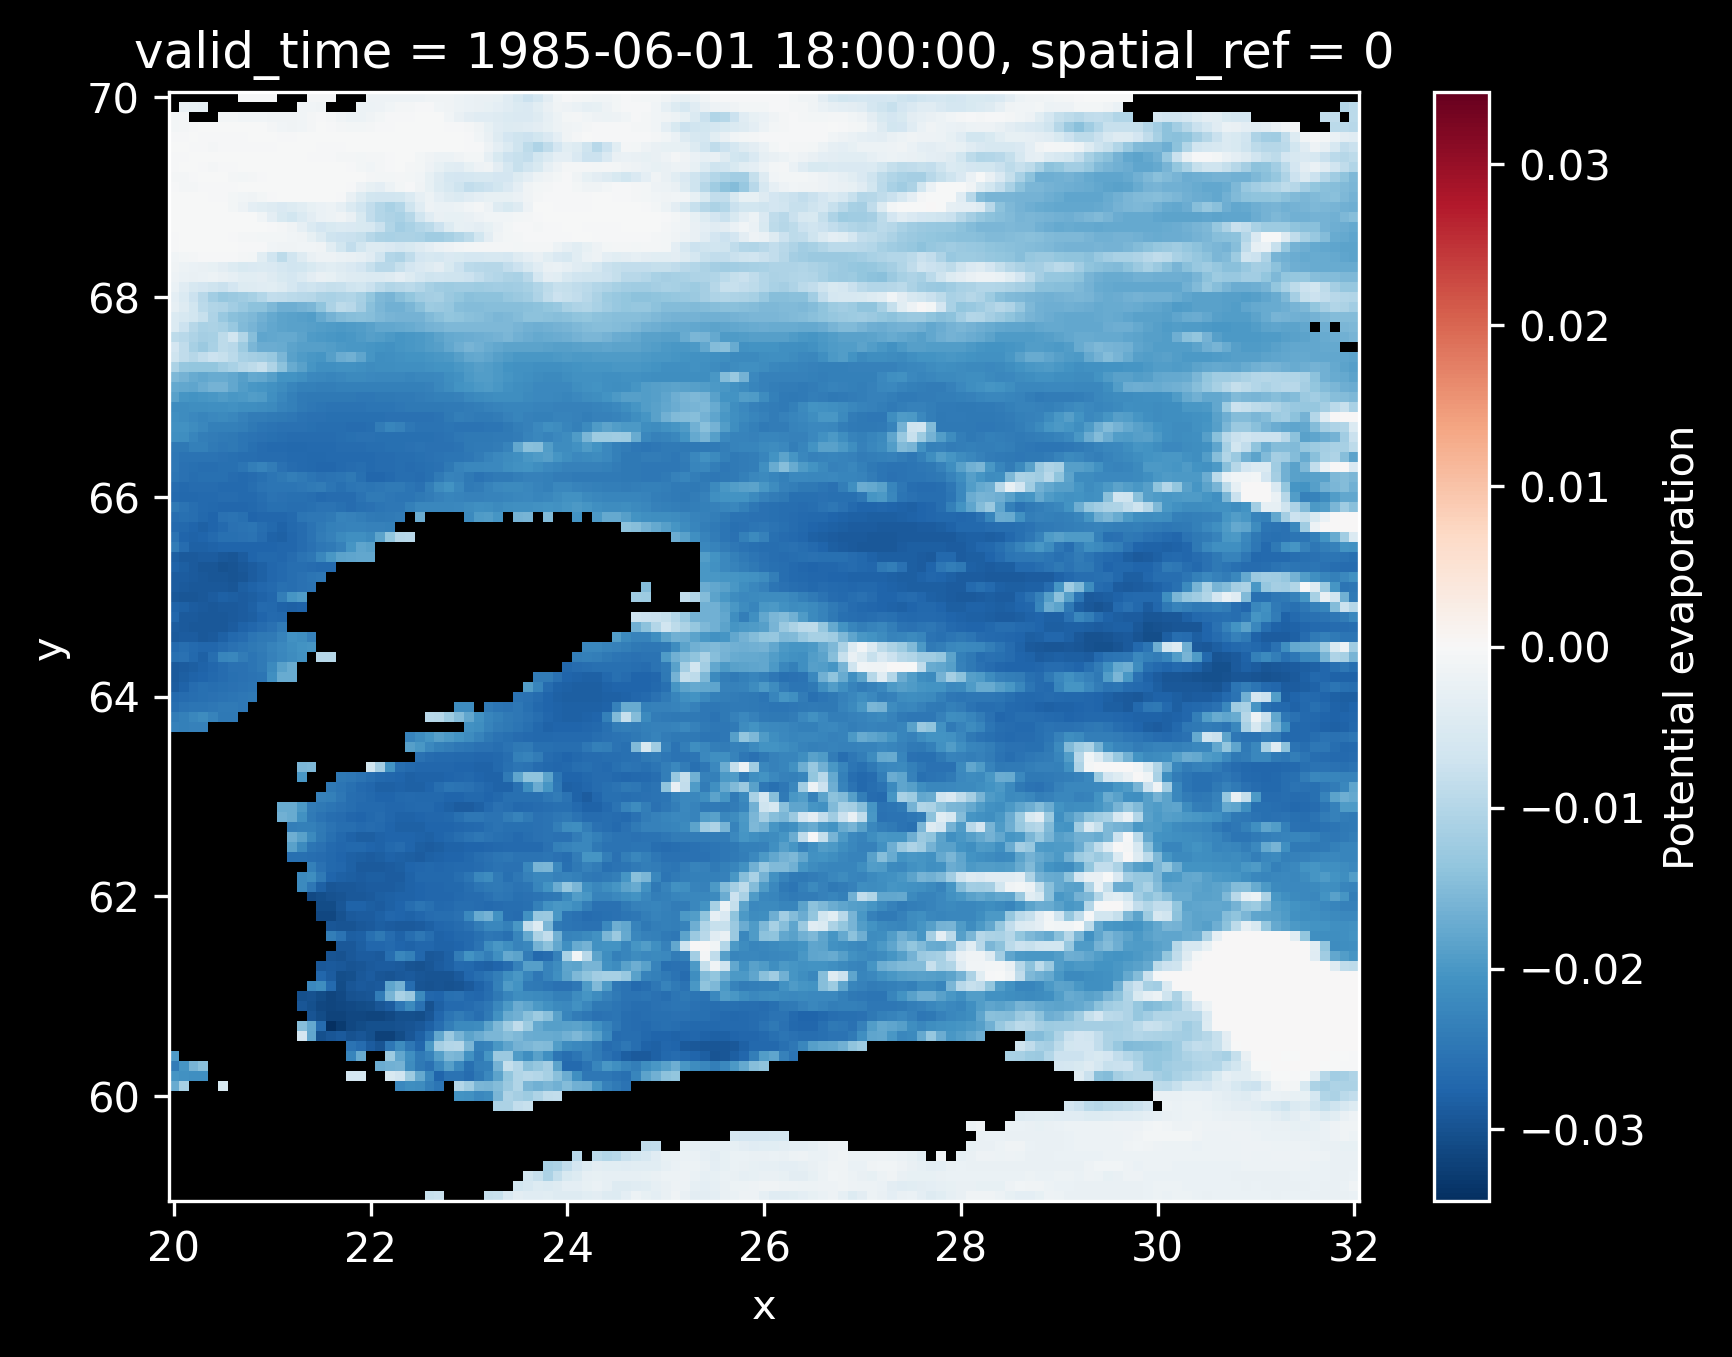

In [33]:
hours[18].plot(cbar_kwargs={'label': one_day_data.long_name})

In [ ]:
def mean_weather_era5_evap(args):
    """ Calculates the daily mean of the given watersheds for one variable, over the time period of one year (and one file)
    Does not return anything, instead writes the result to a csv file of shape (timesteps, catchments)
    """
    src_path,  dst_path, watersheds = args

    weather = pd.DataFrame(index=pd.to_datetime([]), columns=watersheds.Paikka_Id)
    weather.index.name = 'date'

    with rioxr.open_rasterio(src_path, mask_and_scale=True) as data_array:
        # resampling from hourly to daily values. Sum because evaporation is accumulative
        data_array = data_array.resample(valid_time='1D').sum()

        data_array = data_array.rio.write_crs("epsg:4326")
        
        # force load all data to memory, important for the supercomputer
        #data_array = data_array.load()
        # iterating over the days in the file 
        for time_step in data_array.valid_time:
            time = time_step.item()
            one_day_data = data_array.sel({'valid_time':time})

            row = []
            # looks a bit unpythonic but DataFrame.iterrows returns series, not dataframes and it's a hassle to change back
            for i in range(len(watersheds)): 
                watershed = watersheds.iloc[[i]]
                place_id = watershed.Paikka_Id[i]
                
                # Calculating the average of the attribute for the whole catchment
                clipped = one_day_data.rio.clip(watershed.geometry.values, crs=watershed.crs, all_touched=True)
                average = clipped.mean().item()

                """ ERA5 uses meters and evaporation is marked as negative (precipitation is positive)
                This changes that to positive mm, as previous camels use
                """
                average *= -1000
                
                average = round(average, 2)
                

                row.append(average)
            weather.loc[str(time)] = row

    weather.to_csv(dst_path)
    # only for debuggin purposes
    #return weather